In [14]:
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import scipy.io
import matplotlib.pyplot as plt
import math
# from google.colab import files
from random import randrange
from scipy.linalg import block_diag
import time
timestr = time.strftime("%Y%m%d-%H%M%S")
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 13})
import time
from scipy.stats import beta
# from google.colab import files
from datetime import datetime

nowstr = datetime.now().strftime("%m-%d-%Y_%H-%M-%S_")
RK4_time=0
unfold_time=0
model_time=0
grad_time=0
traject_time=0
seed = 1  # seed of random numbers
torch.manual_seed(int(seed)) # initialization of seed of random numbers for pytorch
np.random.seed(seed)
# ave=0
# sum=0
# cnt=0

In [15]:


class L63(nn.Module):
    def __init__(self, T, umin, umax):
        # もろもろのパラメータを定義
        super(L63, self).__init__()

        # 予測区間の長さ？
        self.predictionHorizon = T

        # モデル予測制御をかける時間の長さ
        self.MPCfinalTime = 8000
        #

        # self.MPCfinalTime = 10

        # number of noise paths used for each iteration
        # self.m = 10
        self.m=3
        self.batchSize = 1
        self.lr =10

        self.xave=1.00
        self.xcnt=1.00
        self.xsum=1.00
        self.relu = nn.ReLU()

        self.before=torch.zeros(3,2000)
        self.step=0
        self.state=torch.zeros(3,self.predictionHorizon)
        self.is_first=1

        # 制御入力の大きさの上限と下限
        self.umax = umax
        self.umin = umin

        # システムの初期値
        # self.x0 = torch.tensor(np.array([8.20, 10.08, 23.86]))  # good
        self.x0 = torch.tensor(np.array([0,0,0]))
        self.x1 = torch.tensor(np.array([0,0,0]))
        self.x2 = torch.tensor(np.array([0,0,0]))
        self.x3 = torch.tensor(np.array([0,0,0]))
        self.x4 = torch.tensor(np.array([0,0,0]))
        self.x5 = torch.tensor(np.array([0,0,0]))
        self.x6 = torch.tensor(np.array([0,0,0]))
        self.x7 = torch.tensor(np.array([0,0,0]))
        # for beta distributions...
        # 一様分布
        self.alpha = 1
        self.beta = 1

        # noise の大きさ
        self.minw = -.1
        self.maxw = .1
        # 第二要素にかける数
        self.w2factor = 20

        # いろいろなパラメータ．システムの
        # self.v = nn.Parameter(torch.zeros(1, self.predictionHorizon-1, dtype=torch.double))
        self.v = nn.Parameter(torch.normal(0, 1, size=(3, self.predictionHorizon-1)))
        self.p=torch.tensor(10)
        self.r=torch.tensor(32)
        self.b=torch.tensor(8/3)
        self.Ts = torch.tensor(0.01)

       

    def RK4(self,xold):
        xnew=torch.zeros(3)
        k1=torch.zeros(3)
        k2=torch.zeros(3)
        k3=torch.zeros(3)
        k4=torch.zeros(3)

        k1=self.florenzcontrol(xold)
        k2=self.florenzcontrol(xold+k1*self.Ts/2.)
        k3=self.florenzcontrol(xold+k2*self.Ts/2.)
        k4=self.florenzcontrol(xold+k3*self.Ts)
        
        xnew[0]=xold[0]+self.Ts/6.0*(k1[0]+2.0*k2[0]+2.0*k3[0]+k4[0])
        xnew[1]=xold[1]+self.Ts/6.0*(k1[1]+2.0*k2[1]+2.0*k3[1]+k4[1])
        xnew[2]=xold[2]+self.Ts/6.0*(k1[2]+2.0*k2[2]+2.0*k3[2]+k4[2])
        return xnew

    # self.relu = nn.ReLU()
    # システムを１ステップ進める関数
    def forward(self,x, u):
        self.x0 = self.f(x,u)

    # 飽和関数
    def sat(self, v):
        return torch.sigmoid(v/20)*(self.umax-self.umin)+self.umin
        # return v
    
    def florenz(self,x):
        dxyz=torch.zeros_like(x)
        dxyz[0] = -self.p * x[0] + self.p * x[1]
        dxyz[1] = (self.r - x[2]) * x[0] - x[1] 
        dxyz[2] = x[0] * x[1] - self.b * x[2]
        return dxyz

   
    def florenzcontrol(self, x):
        dxyz=torch.zeros_like(x)
        dxyz[0] = -self.p * x[0].clone() + self.p * x[1].clone()
        dxyz[1] = (self.r - x[2].clone()) * x[0].clone() - x[1].clone()
        dxyz[2] = x[0].clone() * x[1].clone() - self.b * x[2].clone()

        return dxyz
    
     # システムの関数 x(k+1) = f(x(k), u(k), w(k))
    def f(self, x, u):
        x1,y1,z1=self.florenzcontrol(x)
        # dx=self.Ts*torch.cat([x1.reshape(1),y1.reshape(1),z1.reshape(1)],0).view(-1,1,1)
        x_next=torch.zeros(3)
        x_next=self.RK4(x)
        x_next[0]=x_next[0]+u[0]
        x_next[1]=x_next[1]+u[1]
        x_next[2]=x_next[2]+u[2]
        
        return x_next


    # quadratic costs
    def stageCost(self, x, u):
            
        cost=self.relu(-x[0])
        
        return cost
    
    def finalStageCost(self, x):
        cost=self.relu(-x[0])   
        return cost
        

    # ノイズ系列 w が入ってきたときの状態の軌道
    def trajectoryforMPC(self,u):
        x = torch.zeros(3, self.predictionHorizon)
        # t=self.predictionHorizon-1
        x[:, 0] = self.x0.float()+np.random.normal(loc=0,scale=math.sqrt(2),size=3)
            # 最初の時刻の入力は u なので
        x[:, 1] = self.f(x[:, 0], u)
        for i in range(1, self.predictionHorizon-1):
             x[:, i+1] = self.f(x[:, i], self.sat(self.v[:, [i]]))
        return x

    # なぞ
    def sampleJforMPC(self, u, T):
        x = self.trajectoryforMPC(u)
        cost = torch.tensor(0)
        for i in range(T-1):
            cost = cost + self.stageCost(x[:, i], self.sat(self.v[:, [i]]))
        return cost + self.finalStageCost(x[:, T-1])

    # なぞ
    def sampleBatchJforMPC(self, u, T):
        cost = torch.zeros(( self.batchSize))
        for i in range(self.batchSize):
            cost[i] = self.sampleJforMPC(u, T)
        return cost

    # なぞ
    def unfoldTrainForMPC(self, currentInput):
        opt = optim.Adam(self.parameters(), lr=self.lr)
        self.train()
        loss_func = nn.L1Loss()
        for T in range(2, self.predictionHorizon+1):
            target = torch.zeros([1,self.batchSize])
            for i in range(self.m):
                opt.zero_grad()
                loss_func(self.sampleBatchJforMPC(currentInput, T),target).backward(retain_graph=True)
                opt.step()
        # self.u = self.sat(self.v)





In [16]:
# 実際にモデル予測制御をする関数


def MPC(x0, umin, umax):
    predictionHorizon = 50
    cycle=8
    # Model = L63(predictionHorizon, umin, umax)
    # myModel = torch.jit.trace(Model)
    
    myModel = L63(predictionHorizon, umin, umax)
    myModel.x0 = torch.tensor(x0)
    x = np.zeros((3, myModel.MPCfinalTime+1))
    u = np.zeros((3, myModel.MPCfinalTime+1))
    for i in range(int((myModel.MPCfinalTime)/cycle)):
        # print(i)
        # x[:, [i]] = myModel.x0.detach().numpy()
        x[:, cycle*i] = myModel.x0.detach().numpy()
        # etime = myModel.unfoldTrainForMPC(u[:, i])
        myModel.unfoldTrainForMPC(u[:, [i]])
        for j in range(cycle):
            u[:, [cycle*i+j]] = myModel.sat(myModel.v[:, [j]]).detach().numpy()

        # u[0, [i+1]] = myModel.sat(myModel.v[0, [1]]).detach().numpy()
        
        for j in range(cycle):
            myModel.forward(torch.from_numpy(x[:,cycle*i+j].astype(np.float32)).clone(),u[:, cycle*i+j])
            x[:,cycle*i+j+1] = myModel.x0.detach().numpy()
        newx0 = myModel.x0.detach()
        myModel = L63(predictionHorizon, umin, umax)
        myModel.x0 = newx0
      
    x[:, myModel.MPCfinalTime] = myModel.x0.detach().numpy()
    return x, u
  



In [17]:
umin=-0.05773502692
umax=0.05773502692
x01=np.array([12.9825, 16.4453, 32.3303])
 
x1,u1=MPC(x01,umin,umax)

num=10
D=0.1



/home/rk-nagai/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


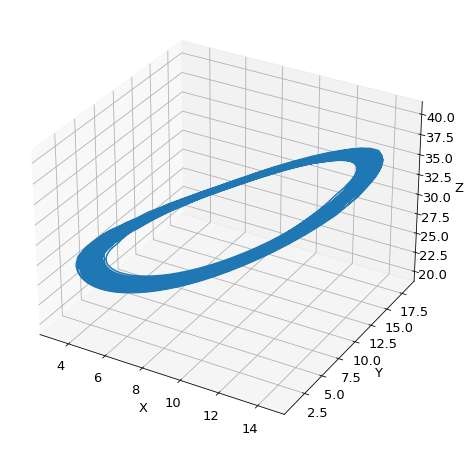

In [18]:
fig = plt.figure(figsize=[8, 8])
ax = fig.add_subplot(projection="3d")
# ax.scatter(*x1[0, :], c="red")
# ax.plot(*x1.transpose())
ax.plot(x1[0],x1[1],x1[2])
plt.xlabel('X')
plt.ylabel('Y')
ax.zlabel=ax.set_zlabel('Z')
plt.savefig(f'D={D}-case{num}-pH=20-8000times-T=1.5.pdf')
plt.show()

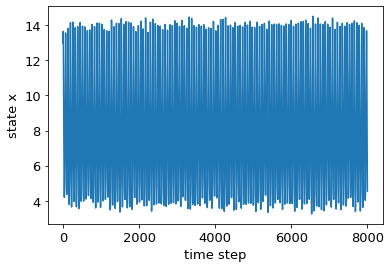

In [19]:
y=np.arange(0,8001)
plt.plot(y,x1[0])
plt.xlabel('time step')
plt.ylabel('state x')
plt.savefig(f'state-x-D={D}-case{num}-pH=20-8000times-T=1.5.pdf')


In [20]:

# 保存先のファイルパス
file_path = f"x-D={D}-case{num}-pH=20-8000times-T=1.5.csv"

# CSVファイルにデータを保存
np.savetxt(file_path, x1[0], delimiter=",", fmt='%f', comments='')

print(f"{file_path} にデータを保存しました。")



x-D=0.1-case10-pH=20-8000times-T=1.5.csv にデータを保存しました。


In [21]:

# 保存先のファイルパス
file_path = f"y-D={D}-case{num}-pH=20-8000times-T=1.5.csv"

# CSVファイルにデータを保存
np.savetxt(file_path, x1[1], delimiter=",", fmt='%f', comments='')

print(f"{file_path} にデータを保存しました。")



y-D=0.1-case10-pH=20-8000times-T=1.5.csv にデータを保存しました。


In [22]:

# 保存先のファイルパス
file_path = f"z-D={D}-case{num}-pH=20-8000times-T=1.5.csv"

# CSVファイルにデータを保存
np.savetxt(file_path, x1[2], delimiter=",", fmt='%f', comments='')

print(f"{file_path} にデータを保存しました。")



z-D=0.1-case10-pH=20-8000times-T=1.5.csv にデータを保存しました。


In [23]:
# 保存先のファイルパス
file_path = f"ux-D={D}-case{num}-pH=20-8000times-T=1.5.csv"

# CSVファイルにデータを保存
np.savetxt(file_path, u1[0], delimiter=",", fmt='%f', comments='')

print(f"{file_path} にデータを保存しました。")

ux-D=0.1-case10-pH=20-8000times-T=1.5.csv にデータを保存しました。


In [24]:
# 保存先のファイルパス
file_path = f"uy-D={D}-case{num}-pH=20-8000times-T=1.5.csv"

# CSVファイルにデータを保存
np.savetxt(file_path, u1[1], delimiter=",", fmt='%f', comments='')

print(f"{file_path} にデータを保存しました。")

uy-D=0.1-case10-pH=20-8000times-T=1.5.csv にデータを保存しました。


In [25]:
# 保存先のファイルパス

file_path=f'uz-D={D}-case{num}-pH=20-8000times-T=1.5.csv'
# file_path = "uz-D=0.2-case20-pH=20-8000times-T=1.5.csv"

# CSVファイルにデータを保存
np.savetxt(file_path, u1[2], delimiter=",", fmt='%f', comments='')

print(f"{file_path} にデータを保存しました。")

uz-D=0.1-case10-pH=20-8000times-T=1.5.csv にデータを保存しました。


In [26]:
u1[:,10:50]

array([[-1.41032413e-03,  1.26252696e-03,  1.42472982e-03,
         3.61513346e-04, -1.14449114e-03,  7.54989684e-04,
        -1.01466104e-03, -1.19316205e-03,  1.46076083e-04,
         2.81743705e-04, -1.70209259e-03, -2.08089501e-03,
         1.07999891e-04,  5.09653240e-04, -4.70876694e-06,
         5.68941981e-02,  5.68456724e-02,  5.69205508e-02,
         5.68739325e-02,  5.69124371e-02,  5.68571612e-02,
         5.67889512e-02,  6.04234636e-04,  1.03730336e-03,
        -7.09854066e-04,  9.12860036e-04,  6.36361539e-04,
        -2.94114649e-03,  1.53375417e-03,  1.11993402e-03,
        -3.43896449e-04, -2.65572965e-03, -8.94408673e-04,
        -1.70281902e-03, -1.22807547e-03,  1.85424089e-03,
        -1.77127495e-03, -5.37190586e-04, -1.16788968e-03,
         2.46715546e-03],
       [ 2.64877081e-03,  1.91110000e-03, -1.01778656e-04,
         5.00809401e-04, -9.43426043e-04, -7.61944801e-04,
        -1.35629997e-03,  5.57329506e-04,  1.51135400e-03,
        -1.05747953e-03, -1.32